# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from L2.sga import SGA
from L2.mutation import reverse_sequence_mutation, transposition_mutation
from L2.replacement import mu_plus_lambda_replacement
from L2.genetic_operator import pmx

%matplotlib inline

## Input data

In [2]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
Distance matrix:
 [[    0.           666.10809934   281.11385594 ...,   217.08293346
    789.38267019  1220.46097848]
 [  666.10809934     0.           649.32657423 ...,   596.25917184
   1421.55724471  1716.04924172]
 [  281.11385594   649.32657423     0.         ...,   463.24939288
    995.3140208   1483.59361012]
 ..., 
 [  217.08293346   596.25917184   463.24939288 ...,     0.           829.60834133
   1150.76061803]
 [  789.38267019  1421.55724471   995.3140208  ...,   829.60834133     0.
    624.81997407]
 [ 1220.46097848  1716.04924172  1483.59361012 ...,  1150.76061803
    624.81997407     0.        ]]
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


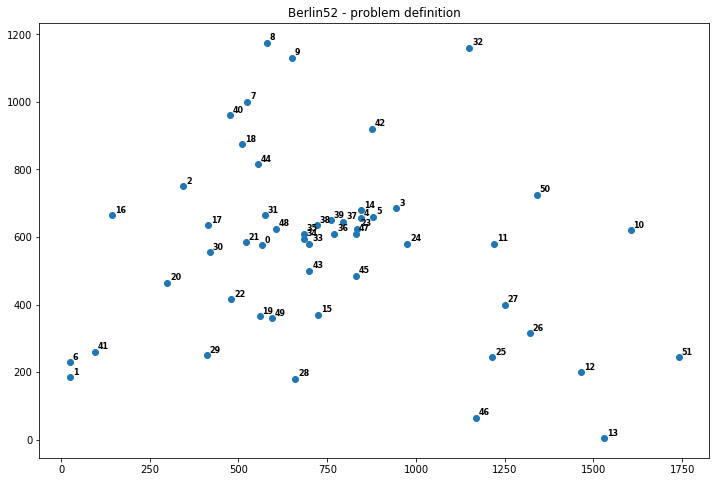

In [3]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

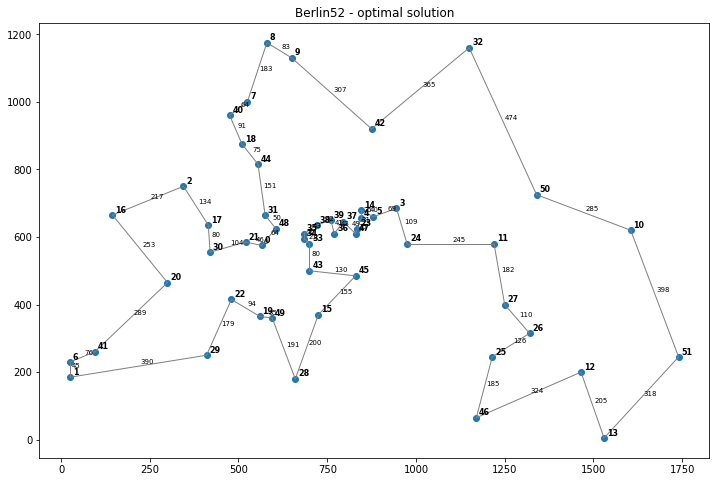

In [4]:
from matplotlib.lines import Line2D

route = p

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

plt.title('Berlin52 - optimal solution')

plt.show()

## Objective function

In [5]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [6]:
print(tsp_objective_function(p), p)

7544.3659019 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## Random Sampling

In [7]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = tsp_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(tsp_objective_function(p), p)

34.842958211898804
21832.1300082 [21  3 14 34 24 22 49  4  7 42 38 23  2 15 33 39 31 36 35 30 20  6 19 16 41
  8 32  0  1 18 10 50 27 29 17 44 40 25 46 13 51 12 47 48  9  5 45 26 28 43
 11 37]


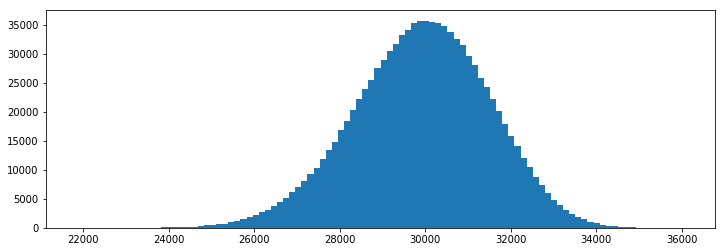

29912.1453343 1581.50359657


In [8]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [9]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [10]:
def simulated_annealing():
    T = 500000
    radius = 1
    alpha = 1.0

    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = tsp_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = tsp_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

    print(time.time() - t0, costs.min())
    return costs

In [11]:
costs = simulated_annealing()

31.867382287979126 8860.613455


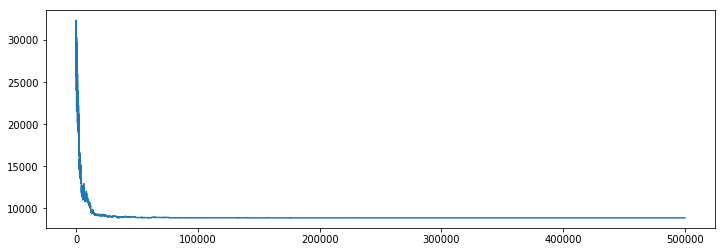

In [12]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

In [13]:
costs2 = simulated_annealing()

32.663644790649414 9147.63349646


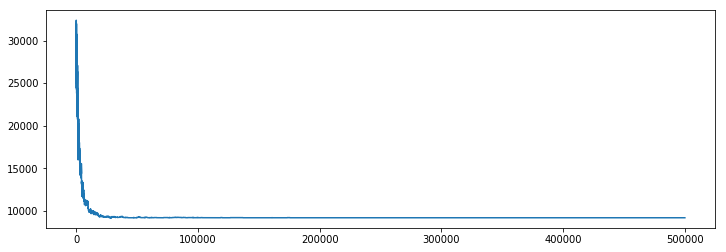

In [14]:
plt.figure(figsize=(12,4))
plt.plot(costs2)
plt.show()

In [15]:
costs3 = simulated_annealing()

32.20273518562317 9883.0893571


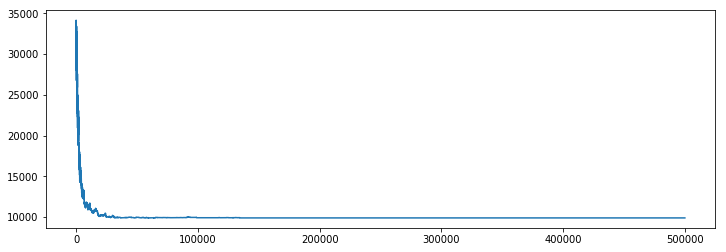

In [16]:
plt.figure(figsize=(12,4))
plt.plot(costs3)
plt.show()

## SGA-PMX

In [36]:
sga_pmx = SGA(tsp_objective_function, chromosome_length=n, 
              mutation=reverse_sequence_mutation,
              replacement=mu_plus_lambda_replacement,
              genetic_operator=pmx)

In [28]:
sga_pmx.evolve(population_size=500,
               number_of_iterations=250,
               crossover_probability=0.95,
               mutation_probability=0.25)

  0     0.08282948 25218.11808725 28490.23041639 29760.20230800 934.27967487
  1     0.14301753 24036.74760461 27448.50329070 28487.20003491 821.01382868
  2     0.20379400 23621.27335163 26661.84779061 27626.13986291 799.39266474
  3     0.26217604 23157.19416988 25858.57613333 26822.35575769 750.00259092
  4     0.32309699 21898.82675039 25289.48976613 26125.28717190 686.62883690
  5     0.38312602 21898.82675039 24736.30331617 25570.76053930 670.46821305
  6     0.44362831 21844.39097798 24267.84551737 25056.01928867 599.48951109
  7     0.50089526 21095.17552272 23833.59965057 24565.07859194 608.05368264
  8     0.55987525 21058.16058844 23444.57906978 24180.24217313 591.49843585
  9     0.61999726 20931.51026298 23070.68624058 23799.14741457 615.38759423
 10     0.67760038 20537.51583414 22672.99230814 23420.09788477 600.24588310
 11     0.73646569 20293.63177913 22302.88955679 23067.23016843 559.80746431
 12     0.79515433 20147.39900137 22013.93954317 22668.28392302 498.77697750

111     5.09405994 8203.25337247 8247.21414453 8389.69688181  41.55191099
112     5.12895370 8203.25337247 8231.62482425 8232.50182974   3.81197619
113     5.16546369 8055.36725601 8217.39988853 8232.50182974  18.72498255
114     5.20070434 8049.01115215 8191.67796666 8213.17885658  51.18397209
115     5.23616195 8049.01115215 8084.60464917 8203.25337247  57.49363867
116     5.27285933 8042.30445084 8055.44242144 8055.66356536   0.73387224
117     5.31568146 8042.30445084 8053.96596616 8055.36725601   3.91350482
118     5.35505438 8042.30445084 8045.93409397 8055.36725601   5.72600069
119     5.39196706 8035.94834699 8042.28867059 8042.30445084   0.29198892
120     5.43135309 8007.62944307 8039.11360606 8042.30445084   3.42395924
121     5.46744967 8007.62944307 8035.77843356 8035.94834699   2.18698225
122     5.50279188 7992.70417770 8015.29697963 8035.94834699  12.64073301
123     5.53995609 7992.70417770 8007.50645210 8007.62944307   1.24238865
124     5.58529615 7992.70417770 8001.

223     9.15860963 7948.97361914 7948.97361914 7948.97361914   0.00000000
224     9.19337821 7948.97361914 7948.97361914 7948.97361914   0.00000000
225     9.22790647 7948.97361914 7948.97361914 7948.97361914   0.00000000
226     9.26298881 7948.97361914 7948.97361914 7948.97361914   0.00000000
227     9.29810071 7948.97361914 7948.97361914 7948.97361914   0.00000000
228     9.33304214 7948.97361914 7948.97361914 7948.97361914   0.00000000
229     9.36933708 7948.97361914 7948.97361914 7948.97361914   0.00000000
230     9.40494514 7948.97361914 7948.97361914 7948.97361914   0.00000000
231     9.44035029 7948.97361914 7948.97361914 7948.97361914   0.00000000
232     9.47511959 7948.97361914 7948.97361914 7948.97361914   0.00000000
233     9.51041436 7948.97361914 7948.97361914 7948.97361914   0.00000000
234     9.54628825 7948.97361914 7948.97361914 7948.97361914   0.00000000
235     9.58253980 7948.97361914 7948.97361914 7948.97361914   0.00000000
236     9.61814141 7948.97361914 7948.

array([ 25218.11808725,  24036.74760461,  23621.27335163,  23157.19416988,
        21898.82675039,  21898.82675039,  21844.39097798,  21095.17552272,
        21058.16058844,  20931.51026298,  20537.51583414,  20293.63177913,
        20147.39900137,  20147.39900137,  19840.33701999,  18947.37493644,
        18051.86892388,  17861.08400322,  17861.08400322,  17729.77600497,
        17445.40222706,  17309.3141029 ,  17290.29706432,  16788.84592683,
        16703.03984229,  16117.68420576,  16117.68420576,  15873.12823453,
        15873.12823453,  15738.3927475 ,  15624.45940068,  15514.57975074,
        14945.90650827,  14945.90650827,  14856.38098469,  14856.38098469,
        14193.26448871,  14193.26448871,  14193.26448871,  14074.80970658,
        13770.32509941,  13770.32509941,  13629.72674651,  13550.33657751,
        13550.33657751,  13473.97293904,  13360.64112168,  12681.94642078,
        12681.94642078,  12681.94642078,  12314.1995876 ,  12314.1995876 ,
        12157.45542406,  

In [30]:
sga_pmx.evolve(population_size=500,
               number_of_iterations=250,
               crossover_probability=0.95,
               mutation_probability=0.25)

  0     0.08774877 25371.13339596 28398.04305582 29636.76410774 946.25982899
  1     0.15328956 24431.53287755 27399.74154561 28471.44559321 847.30255107
  2     0.21760249 23612.73866424 26524.35122746 27540.05613340 813.19409411
  3     0.27835917 23025.73839801 25762.50935030 26695.50808758 722.28261008
  4     0.34434080 22908.64347324 25195.96509378 25984.57686007 657.93341674
  5     0.40986323 19968.87994432 24694.61474314 25503.92750073 672.45988771
  6     0.47222900 19968.87994432 24185.59497473 25008.45321734 737.51137179
  7     0.53792906 19968.87994432 23681.41711720 24544.50004541 809.47596713
  8     0.60181737 19968.87994432 23041.11968623 23997.11874789 868.32736792
  9     0.66431928 19968.87994432 22431.99647194 23468.17304282 883.54355962
 10     0.72505045 19482.63422213 21705.51689852 22760.89552896 794.50829069
 11     0.78092623 18861.97380260 21017.72733915 21908.31863969 619.93644071
 12     0.83479810 18349.66563546 20390.26495404 21071.60300927 459.72966461

112     5.52861834 8419.02165228 8456.21292570 8467.39257772  14.05797129
113     5.57164168 8419.02165228 8444.90447073 8467.39257772  11.18464977
114     5.61340475 8419.02165228 8440.70408490 8447.84942491  10.39691421
115     5.65748239 8399.69867913 8429.75194698 8442.76279165  11.80784384
116     5.69572806 8399.69867913 8418.98300633 8419.02165228   0.86328505
117     5.73141146 8399.69867913 8403.83379538 8419.02165228   7.92486933
118     5.77137351 8399.69867913 8399.69867913 8399.69867913   0.00000000
119     5.81052995 8399.69867913 8399.69867913 8399.69867913   0.00000000
120     5.84818459 8399.69867913 8399.69867913 8399.69867913   0.00000000
121     5.88487506 8399.69867913 8399.69867913 8399.69867913   0.00000000
122     5.92516637 8369.97204083 8399.59061389 8399.69867913   1.70551223
123     5.97713327 8346.27804004 8388.00477113 8399.69867913  13.74606900
124     6.02665186 8346.27804004 8376.77997614 8399.69867913  10.95640586
125     6.07373786 8346.27804004 8370.

223     9.88910651 8056.01166399 8056.01166399 8056.01166399   0.00000000
224     9.92718124 8056.01166399 8056.01166399 8056.01166399   0.00000000
225     9.96504450 8056.01166399 8056.01166399 8056.01166399   0.00000000
226    10.00313687 8056.01166399 8056.01166399 8056.01166399   0.00000000
227    10.04158568 8056.01166399 8056.01166399 8056.01166399   0.00000000
228    10.07983017 8056.01166399 8056.01166399 8056.01166399   0.00000000
229    10.11913300 8056.01166399 8056.01166399 8056.01166399   0.00000000
230    10.15728545 8056.01166399 8056.01166399 8056.01166399   0.00000000
231    10.19563746 8056.01166399 8056.01166399 8056.01166399   0.00000000
232    10.23451519 8056.01166399 8056.01166399 8056.01166399   0.00000000
233    10.27275515 8056.01166399 8056.01166399 8056.01166399   0.00000000
234    10.31091213 8056.01166399 8056.01166399 8056.01166399   0.00000000
235    10.35035110 8056.01166399 8056.01166399 8056.01166399   0.00000000
236    10.38849735 8056.01166399 8056.

In [31]:
sga_pmx.evolve(population_size=500,
               number_of_iterations=250,
               crossover_probability=0.95,
               mutation_probability=0.25)

  0     0.08553457 23909.22157473 28513.73655390 29778.35137260 982.71882318
  1     0.15019822 23909.22157473 27428.11619558 28565.61596296 845.58278180
  2     0.21525002 23011.38093952 26610.77885061 27602.95654788 777.21815223
  3     0.27692509 22947.44508958 25920.50814929 26812.54589985 740.30642172
  4     0.34485579 22184.50479225 25316.38273315 26205.46934376 747.33550963
  5     0.40854549 22025.68836104 24710.15704381 25620.67315884 710.17093976
  6     0.46999598 21611.56380422 24143.13847875 25016.12933416 705.10629655
  7     0.53198195 21267.57020481 23625.84964257 24464.69405808 670.43639613
  8     0.59712887 21208.74565404 23175.65187848 23941.21493545 626.76413424
  9     0.65750265 19440.64679571 22728.29507879 23523.84991145 600.53062389
 10     0.71954226 18750.60491295 22346.97066805 23052.99448607 573.04898219
 11     0.77976608 17684.09005727 21971.97737808 22640.36846126 570.65685148
 12     0.84224701 17684.09005727 21557.65320253 22192.16021403 651.07249232

110     5.12973690 8524.85492946 8529.32442610 8529.48173758   0.83851244
111     5.16767764 8524.85492946 8525.82655916 8529.48173758   1.88453706
112     5.20542169 8524.85492946 8524.85492946 8524.85492946   0.00000000
113     5.24311900 8524.85492946 8524.85492946 8524.85492946   0.00000000
114     5.28083467 8524.85492946 8524.85492946 8524.85492946   0.00000000
115     5.31930113 8524.85492946 8524.85492946 8524.85492946   0.00000000
116     5.35838485 8524.85492946 8524.85492946 8524.85492946   0.00000000
117     5.39637876 8524.85492946 8524.85492946 8524.85492946   0.00000000
118     5.43440580 8524.85492946 8524.85492946 8524.85492946   0.00000000
119     5.47228646 8524.85492946 8524.85492946 8524.85492946   0.00000000
120     5.51067829 8524.85492946 8524.85492946 8524.85492946   0.00000000
121     5.54759264 8524.85492946 8524.85492946 8524.85492946   0.00000000
122     5.58700585 8524.85492946 8524.85492946 8524.85492946   0.00000000
123     5.62484431 8524.85492946 8524.

224     9.48230314 8524.85492946 8524.85492946 8524.85492946   0.00000000
225     9.52066135 8524.85492946 8524.85492946 8524.85492946   0.00000000
226     9.55897188 8524.85492946 8524.85492946 8524.85492946   0.00000000
227     9.59731627 8524.85492946 8524.85492946 8524.85492946   0.00000000
228     9.63558197 8524.85492946 8524.85492946 8524.85492946   0.00000000
229     9.67371511 8524.85492946 8524.85492946 8524.85492946   0.00000000
230     9.71389604 8524.85492946 8524.85492946 8524.85492946   0.00000000
231     9.75179172 8524.85492946 8524.85492946 8524.85492946   0.00000000
232     9.79020524 8524.85492946 8524.85492946 8524.85492946   0.00000000
233     9.82895994 8524.85492946 8524.85492946 8524.85492946   0.00000000
234     9.86811924 8524.85492946 8524.85492946 8524.85492946   0.00000000
235     9.90617132 8524.85492946 8524.85492946 8524.85492946   0.00000000
236     9.94611573 8524.85492946 8524.85492946 8524.85492946   0.00000000
237     9.98510695 8524.85492946 8524.

In [38]:
best, best_chromosome = sga_pmx.evolve(population_size=500,
                                       number_of_iterations=250,
                                       crossover_probability=0.95,
                                       mutation_probability=0.25)

  0     0.08460569 24268.82095723 28274.99882550 29530.63655910 1018.36290460
  1     0.14705348 24268.82095723 27221.75745217 28393.64787889 883.21440393
  2     0.21052194 23100.67847093 26346.82723878 27375.50039375 763.56613087
  3     0.27433157 21562.10366973 25657.13170883 26587.24770985 728.27128080
  4     0.33741260 21562.10366973 25039.63231041 25869.50163032 672.25118433
  5     0.39986587 21562.10366973 24496.28685161 25297.30919194 699.40011925
  6     0.46349525 21562.10366973 23951.61195290 24816.90614678 678.23195739
  7     0.52672434 20764.16410628 23441.19749288 24231.38464584 636.05009236
  8     0.59070015 20293.21931060 22938.71380891 23713.68153039 630.09145189
  9     0.65424538 19655.47508087 22530.46099027 23257.62724841 585.05900517
 10     0.71415591 19655.47508087 22037.93873785 22734.57696465 531.44788891
 11     0.77202559 19505.19348876 21603.93748025 22200.92074743 502.16580108
 12     0.83164859 19295.05045231 21212.25084528 21814.04214098 494.8324873

114     5.55136299 8308.82738243 8329.47825376 8330.16484900   2.99794899
115     5.59199452 8294.59104254 8320.11710061 8330.16484900   7.28124094
116     5.63196468 8291.03712680 8314.79100052 8315.92850911   4.08946419
117     5.67650938 8269.69966023 8306.68869363 8315.92850911   9.41033932
118     5.71717572 8235.31187862 8295.61288685 8308.82738243   7.10810218
119     5.75690913 8235.31187862 8292.03634496 8294.59104254   7.19678652
120     5.79941154 8233.91190292 8277.28606428 8294.59104254  11.95568665
121     5.83963299 8233.91190292 8268.48748986 8269.69966023   6.40093191
122     5.88674569 8230.71144855 8251.71670120 8269.69966023  17.68789957
123     5.93482757 8230.71144855 8234.95067967 8269.69966023   4.99764315
124     5.98076057 8230.71144855 8233.89910110 8233.91190292   0.20200927
125     6.01847172 8230.41513920 8231.45976225 8233.91190292   1.35537549
126     6.05633616 8230.41513920 8230.70967069 8230.71144855   0.02288306
127     6.09488606 8230.41513920 8230.

227    10.00294280 8098.30863733 8098.30863733 8098.30863733   0.00000000
228    10.04305291 8098.30863733 8098.30863733 8098.30863733   0.00000000
229    10.08321428 8098.30863733 8098.30863733 8098.30863733   0.00000000
230    10.12335062 8098.30863733 8098.30863733 8098.30863733   0.00000000
231    10.16300344 8098.30863733 8098.30863733 8098.30863733   0.00000000
232    10.20108128 8098.30863733 8098.30863733 8098.30863733   0.00000000
233    10.24281359 8098.30863733 8098.30863733 8098.30863733   0.00000000
234    10.28382730 8098.30863733 8098.30863733 8098.30863733   0.00000000
235    10.32392764 8098.30863733 8098.30863733 8098.30863733   0.00000000
236    10.36395836 8098.30863733 8098.30863733 8098.30863733   0.00000000
237    10.40454555 8098.30863733 8098.30863733 8098.30863733   0.00000000
238    10.44466400 8098.30863733 8098.30863733 8098.30863733   0.00000000
239    10.48504233 8098.30863733 8098.30863733 8098.30863733   0.00000000
240    10.52499938 8098.30863733 8098.

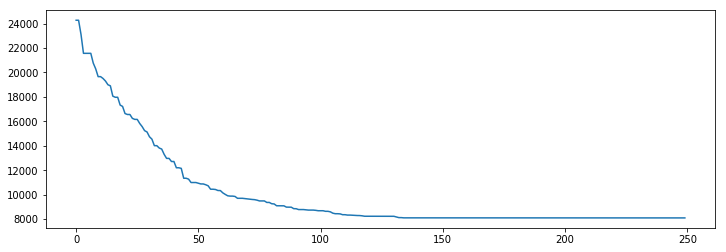

In [39]:
plt.figure(figsize=(12,4))
plt.plot(best)
plt.show()

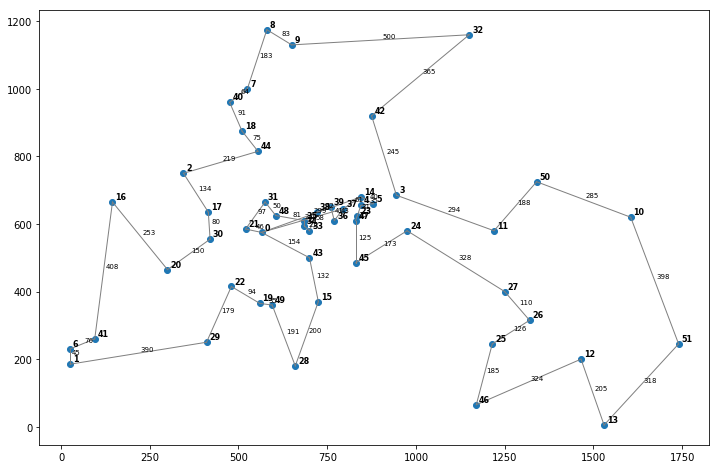

In [43]:
from matplotlib.lines import Line2D

route = best_chromosome
coords = coords.astype("int")

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})


plt.show()

In [193]:
sga_pmx_transopsition = SGA(tsp_objective_function, chromosome_length=n,
                            mutation=transposition_mutation,
                            replacement=mu_plus_lambda_replacement,
                            genetic_operator=pmx)

In [194]:
best_transposition, best_chromosome_transposition = sga_pmx_transopsition.evolve(
    population_size=500,
    number_of_iterations=250,
    crossover_probability=0.95,
    mutation_probability=0.25
)

  0     0.08845067 24648.76337958 28391.30053110 29643.42596944 1014.05136268
  1     0.14998484 23321.13017553 27273.26694164 28440.38877913 935.48083744
  2     0.21188307 22022.98054149 26368.94693000 27484.39256467 867.66272060
  3     0.27269268 22022.98054149 25617.47861764 26587.45897819 833.22063927
  4     0.33472681 21865.84043939 24987.72611344 25928.88318592 814.03588639
  5     0.39525914 21718.93815622 24302.28957754 25306.87194833 788.82918054
  6     0.45635366 20781.79218524 23754.56490580 24679.22969833 713.09517183
  7     0.51902485 20468.99651562 23293.72670817 24140.93854782 687.68859801
  8     0.58248377 20468.99651562 22865.79190025 23652.89224026 671.37600603
  9     0.64088130 20097.77369982 22431.20023491 23239.52204846 621.36020823
 10     0.69924641 19703.09962893 22051.79765025 22793.92599092 596.08813321
 11     0.75776267 19363.33260965 21648.69215135 22377.18032812 577.73039071
 12     0.81518245 17828.11660935 21236.78552326 21942.21384717 591.5350746

109     4.64672017 10878.57097085 10878.57097085 10878.57097085   0.00000000
110     4.68373919 10878.57097085 10878.57097085 10878.57097085   0.00000000
111     4.71989608 10878.57097085 10878.57097085 10878.57097085   0.00000000
112     4.75610304 10878.57097085 10878.57097085 10878.57097085   0.00000000
113     4.79265571 10878.57097085 10878.57097085 10878.57097085   0.00000000
114     4.82850933 10878.57097085 10878.57097085 10878.57097085   0.00000000
115     4.86598778 10878.57097085 10878.57097085 10878.57097085   0.00000000
116     4.90316129 10878.57097085 10878.57097085 10878.57097085   0.00000000
117     4.93981361 10878.57097085 10878.57097085 10878.57097085   0.00000000
118     4.97679424 10878.57097085 10878.57097085 10878.57097085   0.00000000
119     5.01390123 10878.57097085 10878.57097085 10878.57097085   0.00000000
120     5.05130792 10878.57097085 10878.57097085 10878.57097085   0.00000000
121     5.09067583 10878.57097085 10878.57097085 10878.57097085   0.00000000

217     8.62802887 10878.57097085 10878.57097085 10878.57097085   0.00000000
218     8.66517615 10878.57097085 10878.57097085 10878.57097085   0.00000000
219     8.70151329 10878.57097085 10878.57097085 10878.57097085   0.00000000
220     8.73935962 10878.57097085 10878.57097085 10878.57097085   0.00000000
221     8.77585459 10878.57097085 10878.57097085 10878.57097085   0.00000000
222     8.81245565 10878.57097085 10878.57097085 10878.57097085   0.00000000
223     8.85172296 10878.57097085 10878.57097085 10878.57097085   0.00000000
224     8.88907409 10878.57097085 10878.57097085 10878.57097085   0.00000000
225     8.92559123 10878.57097085 10878.57097085 10878.57097085   0.00000000
226     8.96253514 10878.57097085 10878.57097085 10878.57097085   0.00000000
227     8.99899578 10878.57097085 10878.57097085 10878.57097085   0.00000000
228     9.03592443 10878.57097085 10878.57097085 10878.57097085   0.00000000
229     9.07316661 10878.57097085 10878.57097085 10878.57097085   0.00000000

In [195]:
transposition_mutation(np.array([2, 1, 3, 7]))

array([3, 1, 2, 7])

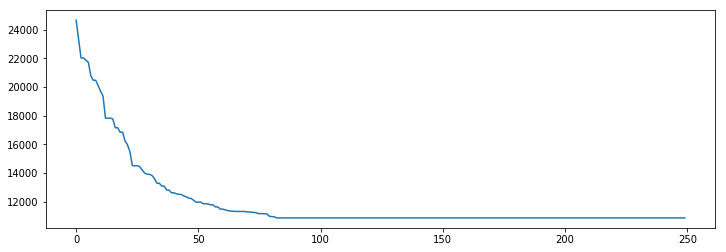

In [196]:
plt.figure(figsize=(12,4))
plt.plot(best_transposition)
plt.show()

In [197]:
best_transposition, best_chromosome_transposition = sga_pmx_transopsition.evolve(
    population_size=500,
    number_of_iterations=250,
    crossover_probability=0.95,
    mutation_probability=0.25
)

  0     0.08508182 24738.70245966 28433.04685216 29810.61305177 1043.05035310
  1     0.14663363 23688.87054798 27273.10004137 28367.21761014 843.26584489
  2     0.20963836 22437.67863022 26459.05901948 27465.34322181 841.98170188
  3     0.27114439 21823.00046190 25603.12085648 26670.17800030 856.60291249
  4     0.33457613 21823.00046190 24870.74714715 25887.25308000 779.64251050
  5     0.39513230 21117.22902281 24316.32600857 25196.86002354 704.22153942
  6     0.45479894 21117.22902281 23740.17696643 24642.93500907 703.93524133
  7     0.51393986 20233.05446172 23235.13284177 24036.07990313 688.74661687
  8     0.57189584 19925.75499597 22701.60849884 23560.85689449 726.89159990
  9     0.62764335 19221.76007469 22064.32471440 22926.32268162 691.91870616
 10     0.68390536 19167.14004725 21553.97613362 22389.55697925 624.09083020
 11     0.73693323 19167.14004725 21094.87139295 21851.50651330 550.59552441
 12     0.79060316 19167.14004725 20677.97140888 21300.63371024 464.3463021

109     4.61027598 11287.89258140 11287.89258140 11287.89258140   0.00000000
110     4.64693666 11287.89258140 11287.89258140 11287.89258140   0.00000000
111     4.68353677 11278.72248269 11287.87424120 11287.89258140   0.40968898
112     4.72018886 11201.78101770 11280.93825795 11287.89258140   5.35096609
113     4.75744271 11201.78101770 11277.33753632 11278.72248269  10.22945386
114     4.79363728 11201.78101770 11219.59031336 11278.72248269  32.31507007
115     4.83151436 11201.78101770 11201.78101770 11201.78101770   0.00000000
116     4.86766744 11201.78101770 11201.78101770 11201.78101770   0.00000000
117     4.90415335 11201.78101770 11201.78101770 11201.78101770   0.00000000
118     4.94064546 11201.78101770 11201.78101770 11201.78101770   0.00000000
119     4.97701716 11201.78101770 11201.78101770 11201.78101770   0.00000000
120     5.01382279 11201.78101770 11201.78101770 11201.78101770   0.00000000
121     5.05220842 11164.61048268 11201.70667663 11201.78101770   1.66065371

217     8.56066322 11164.61048268 11164.61048268 11164.61048268   0.00000000
218     8.59627438 11164.61048268 11164.61048268 11164.61048268   0.00000000
219     8.63268805 11164.61048268 11164.61048268 11164.61048268   0.00000000
220     8.66865468 11164.61048268 11164.61048268 11164.61048268   0.00000000
221     8.70485640 11164.61048268 11164.61048268 11164.61048268   0.00000000
222     8.74088812 11164.61048268 11164.61048268 11164.61048268   0.00000000
223     8.77960801 11164.61048268 11164.61048268 11164.61048268   0.00000000
224     8.81533289 11164.61048268 11164.61048268 11164.61048268   0.00000000
225     8.85168624 11164.61048268 11164.61048268 11164.61048268   0.00000000
226     8.88761258 11164.61048268 11164.61048268 11164.61048268   0.00000000
227     8.92387319 11164.61048268 11164.61048268 11164.61048268   0.00000000
228     8.96122861 11164.61048268 11164.61048268 11164.61048268   0.00000000
229     8.99806046 11164.61048268 11164.61048268 11164.61048268   0.00000000

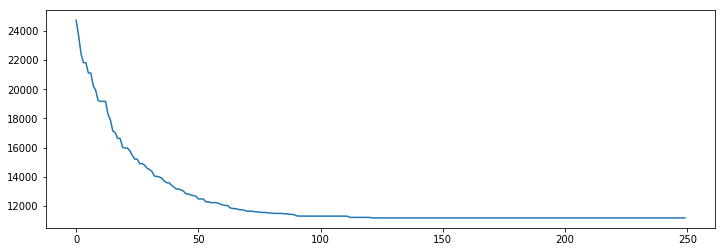

In [198]:
plt.figure(figsize=(12,4))
plt.plot(best_transposition)
plt.show()

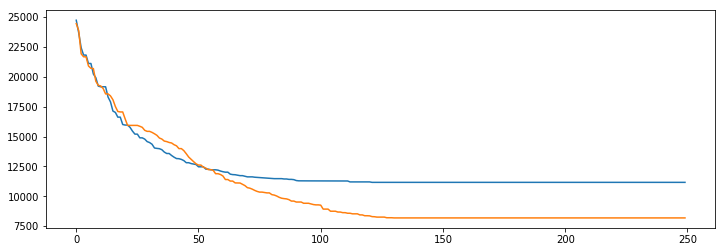

In [203]:
plt.figure(figsize=(12,4))
plt.plot(best_transposition)
plt.plot(best)
plt.show()